In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import matplotlib.pyplot as plt
import pickle
from sklearn.utils import shuffle
import csv
import os

In [ ]:
figsize_default = plt.rcParams['figure.figsize']
mu=0
sigma=0.1


## Flags
Trained_M=False
Vis_Data=False
Sum_Data=False
if Trained_M==False:
    Vis_Data=True
    Sum_Data=True

In [3]:
###############################################################################
## Functions


def Data_histogram_plot(dataset, label):
    hist, bins = np.histogram(dataset, bins=n_classes)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.xlabel(label)
    plt.ylabel("Image count")
    plt.show()

def Data_view(dataset,labels,n_classes):
    plt.rcParams['figure.figsize'] = (20.0, 20.0)
    histo = [0 for i in range(n_classes)]
    samples = {}
    for idx, l in enumerate(labels):
        histo[l] += 1
        if l not in samples:
            samples[l] = dataset[idx]
    total_class = len(set(labels))
    ncols = 4
    nrows = 11

    print("total tests {}. total labels: {}".format(len(dataset), total_class))
    _, axes = plt.subplots(nrows=nrows, ncols=ncols)

    class_idx = 0
    for r in range(nrows):
        for c in range(ncols):
            a = axes[r][c]
            a.axis('off')
            if class_idx in samples:
                cmap = 'gray' if len(samples[class_idx].shape) == 2 else None
                a.imshow(samples[class_idx],cmap=cmap)
                a.set_title("No.{} {}({})".format(class_idx, signs[class_idx], histo[class_idx]), fontsize=13)
            class_idx += 1
    plt.rcParams['figure.figsize'] = figsize_default

def gray_scale(image):
   
   
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)


def image_normalize(image):
#    image = np.divide(image, 255)
    image = (image - image.mean())/image.std()
    return image
    
def Preprocess_Data(dataset):
    
    gray_images = list(map(gray_scale, dataset))
    normalized_images=np.zeros((len(gray_images),gray_images[0].shape[0],gray_images[0].shape[1]))
    for i, img in enumerate(gray_images):
        normalized_images[i] = image_normalize(img)
    normalized_images = normalized_images[..., None]
    return normalized_images
    
def conv_fn(input, in_WH, in_D, out_WH, out_D):

    filter_WH = in_WH - out_WH + 1
    strides = [1,1,1,1]
    W = tf.Variable(tf.truncated_normal(shape=(filter_WH, filter_WH, in_D, out_D), \
                                        mean = mu, stddev = sigma))
    b = tf.Variable(tf.zeros(out_D))
    model = tf.nn.conv2d(input, W, strides=strides, padding='VALID') + b
    return model
    
def linear_fn(input, in_WH, out_WH):
    W = tf.Variable(tf.truncated_normal(shape=(in_WH, out_WH), \
                                        mean=mu, stddev = sigma))
    b = tf.Variable(tf.zeros(out_WH))
    model = tf.matmul(input, W) + b
    return model
    
def Predict(X_data,logits,BATCH_SIZE=64):
    num_examples = len(X_data)
    y_pred = np.zeros(num_examples, dtype=np.int32)
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x = X_data[offset:offset+BATCH_SIZE]
        y_pred[offset:offset+BATCH_SIZE] = sess.run(tf.argmax(logits, 1), 
                           feed_dict={x:batch_x, keep_prob:1, keep_prob_conv:1})
    return y_pred
    
def evaluate(X_data, y_data, BATCH_SIZE=64):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, 
                            feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0, keep_prob_conv: 1.0 })
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples    


In [4]:
###############################################################################
## Loading Data
#Download the Data from https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip

training_file = "./Data_Input/train.p"
validation_file= "./Data_Input/valid.p"
testing_file = "./Data_Input/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
# Mapping ClassID to traffic sign names
signs = []
with open('./Data_Input/signnames.csv', 'r') as csvfile:
    signnames = csv.reader(csvfile, delimiter=',')
    next(signnames,None)
    for row in signnames:
#        print(row)
        signs.append(row[1])
    csvfile.close()
#print(signs)
 

In [5]:
###############################################################################  
## Dataset Summary

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

#if Sum_Data==True:
# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples
n_test = X_test.shape[0]

# Number of validation examples.
n_validation = X_valid.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples: ", n_train)
print("Number of testing examples: ", n_test)
print("Number of validation examples: ", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples:  34799
Number of testing examples:  12630
Number of validation examples:  4410
Image data shape = (32, 32, 3)
Number of classes = 43


total tests 34799. total labels: 43
Here we see the sample for each class


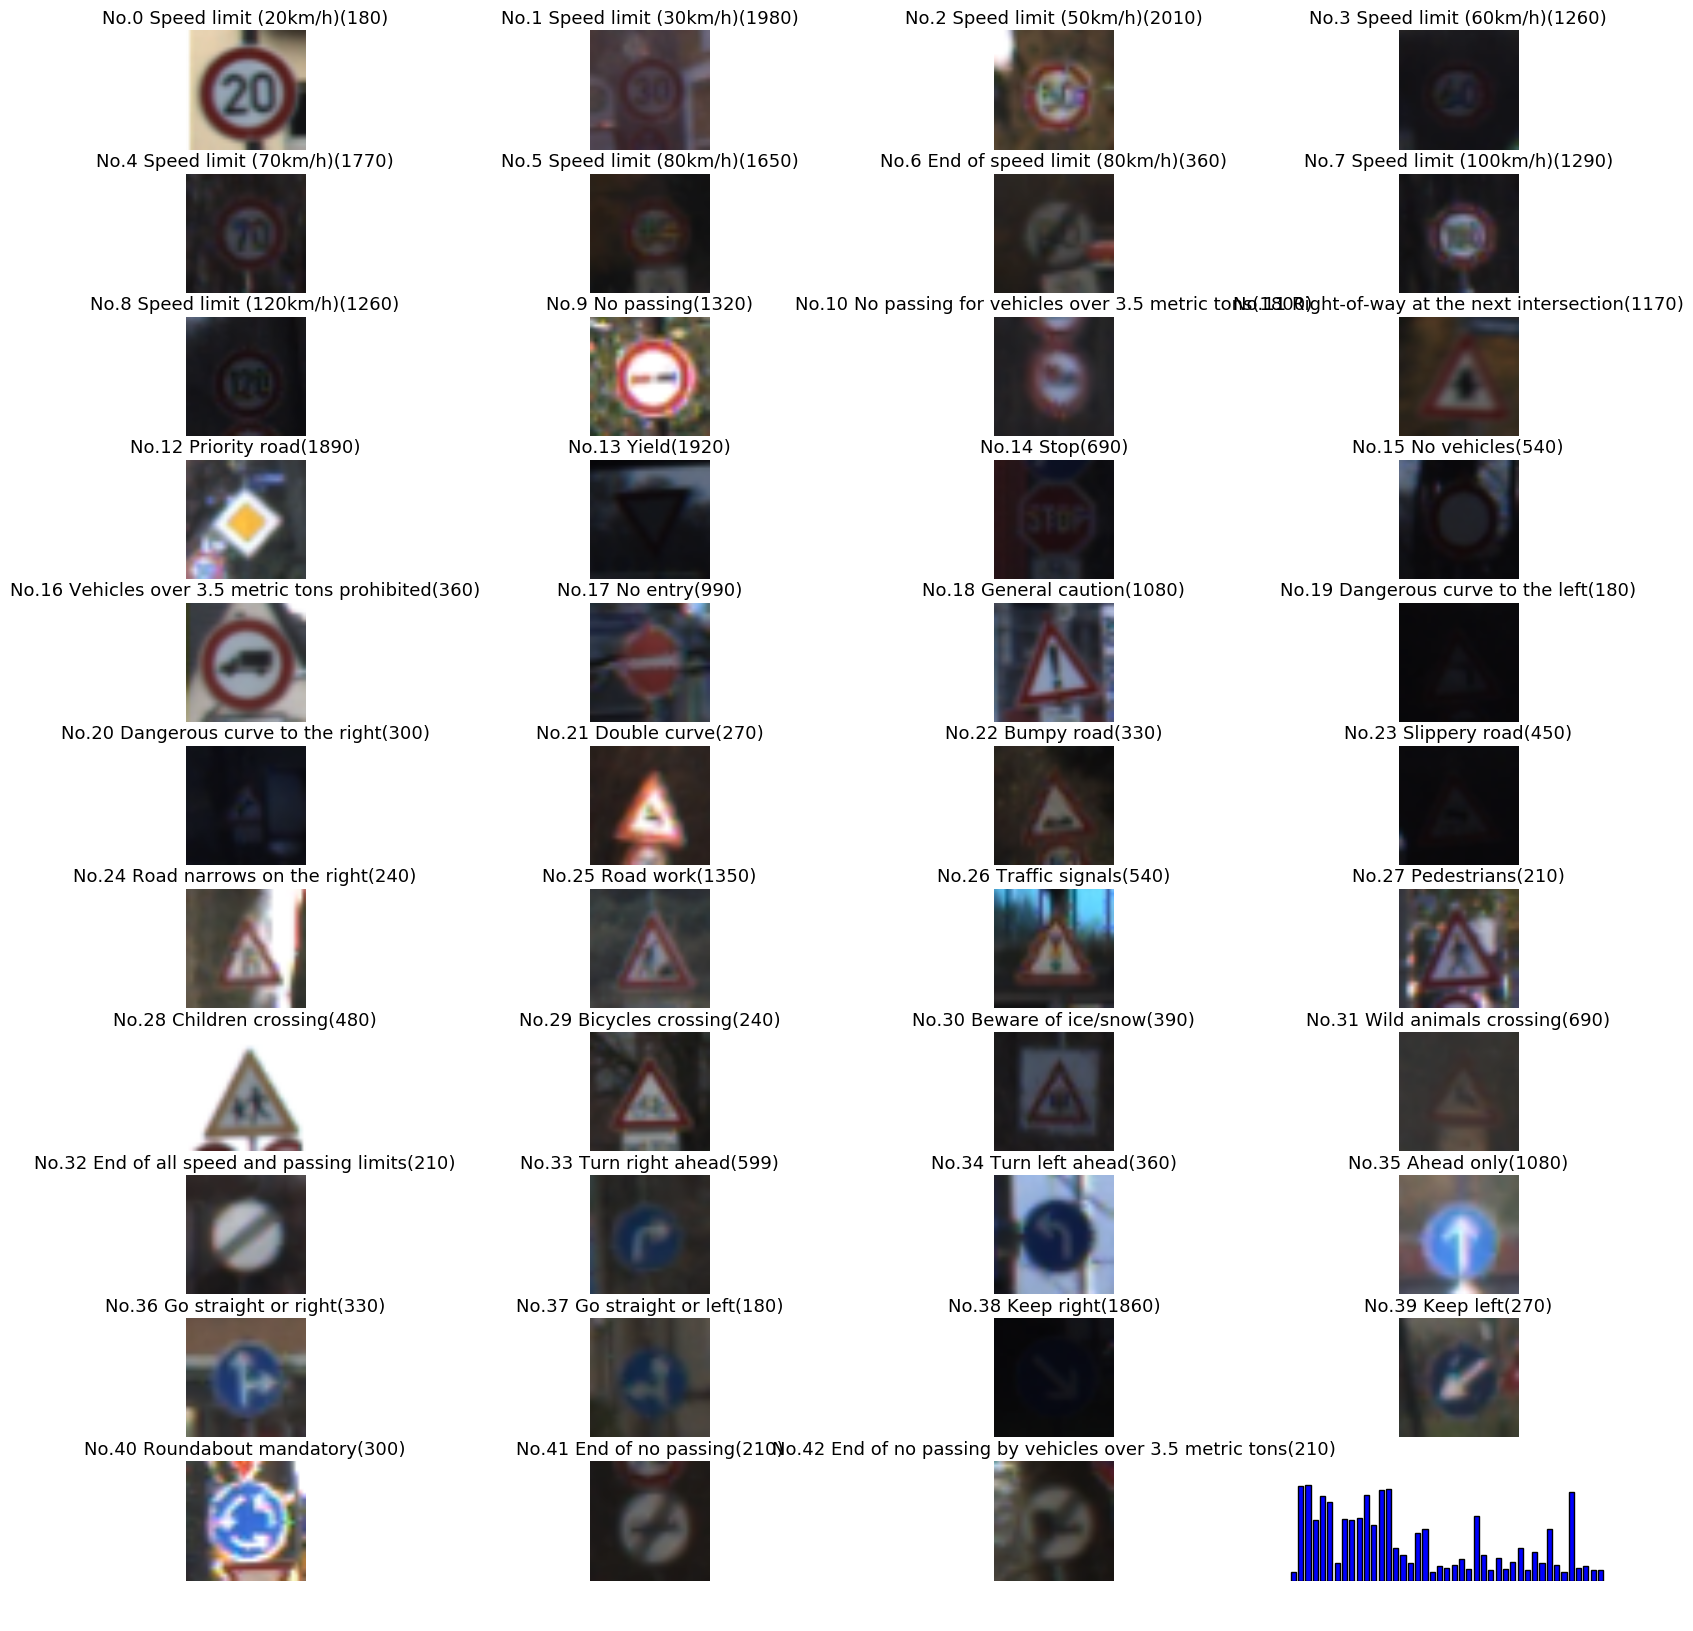

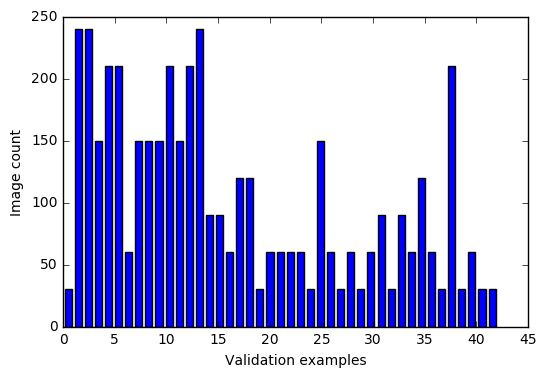

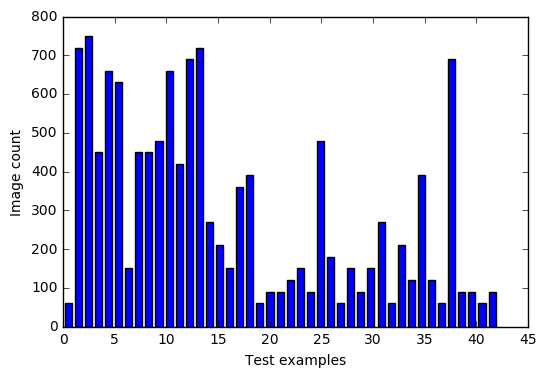

In [6]:
###############################################################################
## Data Exploratory Visualization

if Vis_Data==True:
   
    Data_view(X_train,y_train,len(np.unique(y_train)))
    print("Here we see the sample for each class")
    Data_histogram_plot(y_train, "Training examples")
    Data_histogram_plot(y_valid, "Validation examples")
    Data_histogram_plot(y_test, "Test examples")
    


In [7]:
###############################################################################
## Data Preprocessing

X_train, y_train = shuffle(X_train, y_train)
Preprocessed_data=Preprocess_Data(X_train)



In [8]:
###############################################################################    
## Model Architecture

def LaNet(input):
    ## Layer1
    # convolution layer: 32x32x1 -> 28x28x6
    conv1 = conv_fn(input, 32, 1, 28, 6)
    conv1 = tf.nn.relu(conv1,name='convolution0')
    # pooling: 28x28x12 -> 14x14x6
    conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID',name='convolution1')
    
    ## Layer2
    # convolution layer 14x14x6 -> 10x10x16
    conv2 = conv_fn(conv1, 14, 6, 10, 16)
    conv2 = tf.nn.relu(conv2,name='convolution2')
    conv2 = tf.nn.dropout(conv2, keep_prob_conv)
    # pooling: 10x10x16 -> 5x5x16
    conv2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID',name='convolution3')
    

    
    ## Layer3
    # Flattening: Input = 5x5x16. Output = 400
    flat = tf.contrib.layers.flatten(conv2)
    flat = tf.nn.dropout(flat, keep_prob)
    layer3 = linear_fn(flat, 400, 120)
    layer3 = tf.nn.relu(layer3)
    

    
    ## Layer4
    layer4 = linear_fn(layer3, 120, 84)
    layer4 = tf.nn.relu(layer4)
    
    ## Layer 5
    output = linear_fn(layer4, 84, 43)
    return output


In [9]:
###############################################################################
## Model Training & Solution Approach

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32) 
keep_prob_conv = tf.placeholder(tf.float32)
LaNet_Logits=LaNet(x)
one_hot_y = tf.one_hot(y, n_classes)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=LaNet_Logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(LaNet_Logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()
model_file = './models'

EPOCHS = 50
BATCH_SIZE = 64

def train(X_data, y_data,X_val,y_val):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        print("starting ...")
        for i in range(EPOCHS):
            X_train, y_train = shuffle(X_data, y_data)
            for offset in range(0, len(X_train), BATCH_SIZE):
                end = offset + BATCH_SIZE
                features, labels = X_train[offset:end], y_train[offset:end]
#                %sess.run(training_operation, feed_dict={x : features, y : labels, keep_prob: 0.8})
                sess.run(training_operation, feed_dict={x: features, y: labels, keep_prob : 0.5, keep_prob_conv: 0.7})
            validation_accuracy  = evaluate(X_val, y_val)
            print("EPOCH {} : Validation Accuracy = {:.3f}%".format(i+1, (validation_accuracy*100)))

        saver.save(sess, model_file);
        print("Model saved ")
        
X_val=Preprocess_Data(X_valid)
train(Preprocessed_data,y_train,X_val,y_valid)


starting ...
EPOCH 1 : Validation Accuracy = 83.719%
EPOCH 2 : Validation Accuracy = 89.592%
EPOCH 3 : Validation Accuracy = 91.542%
EPOCH 4 : Validation Accuracy = 91.791%
EPOCH 5 : Validation Accuracy = 93.039%
EPOCH 6 : Validation Accuracy = 94.240%
EPOCH 7 : Validation Accuracy = 92.834%
EPOCH 8 : Validation Accuracy = 94.807%
EPOCH 9 : Validation Accuracy = 94.127%
EPOCH 10 : Validation Accuracy = 95.306%
EPOCH 11 : Validation Accuracy = 95.624%
EPOCH 12 : Validation Accuracy = 94.853%
EPOCH 13 : Validation Accuracy = 95.556%
EPOCH 14 : Validation Accuracy = 95.692%
EPOCH 15 : Validation Accuracy = 96.077%
EPOCH 16 : Validation Accuracy = 95.351%
EPOCH 17 : Validation Accuracy = 96.100%
EPOCH 18 : Validation Accuracy = 96.122%
EPOCH 19 : Validation Accuracy = 95.533%
EPOCH 20 : Validation Accuracy = 96.054%
EPOCH 21 : Validation Accuracy = 95.556%
EPOCH 22 : Validation Accuracy = 96.100%
EPOCH 23 : Validation Accuracy = 96.032%
EPOCH 24 : Validation Accuracy = 95.760%
EPOCH 25 : V

In [10]:
###############################################################################
## Test Dataset Model Architecture
test_preprocessed=Preprocess_Data(X_test)
with tf.Session() as sess:
#    tf.reset_default_graph()
    saver.restore(sess, model_file)
    y_pred = Predict(test_preprocessed,LaNet_Logits)
    test_accuracy = sum(y_test == y_pred)/len(y_test)
    print("Test Accuracy = {:.1f}%".format(test_accuracy*100))


INFO:tensorflow:Restoring parameters from ./models
Test Accuracy = 95.1%


Number of new testing examples:  5


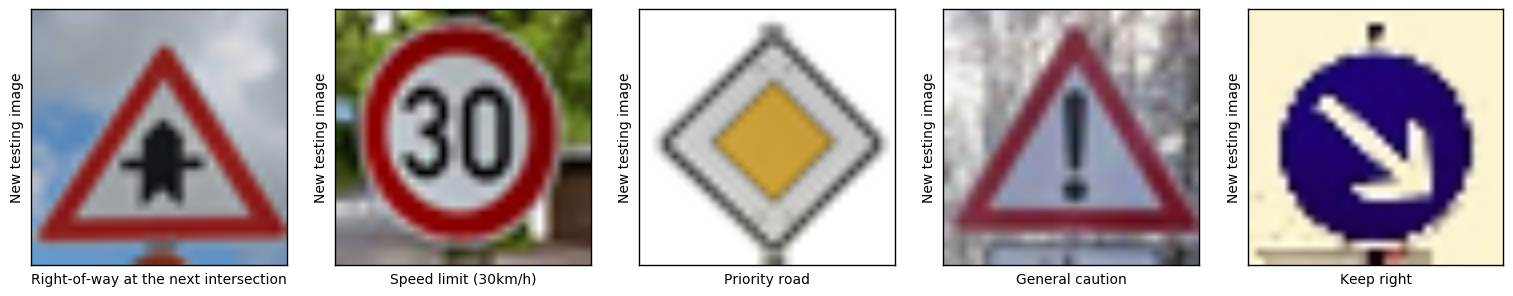

INFO:tensorflow:Restoring parameters from ./models
New Images Test Accuracy = 100.0%


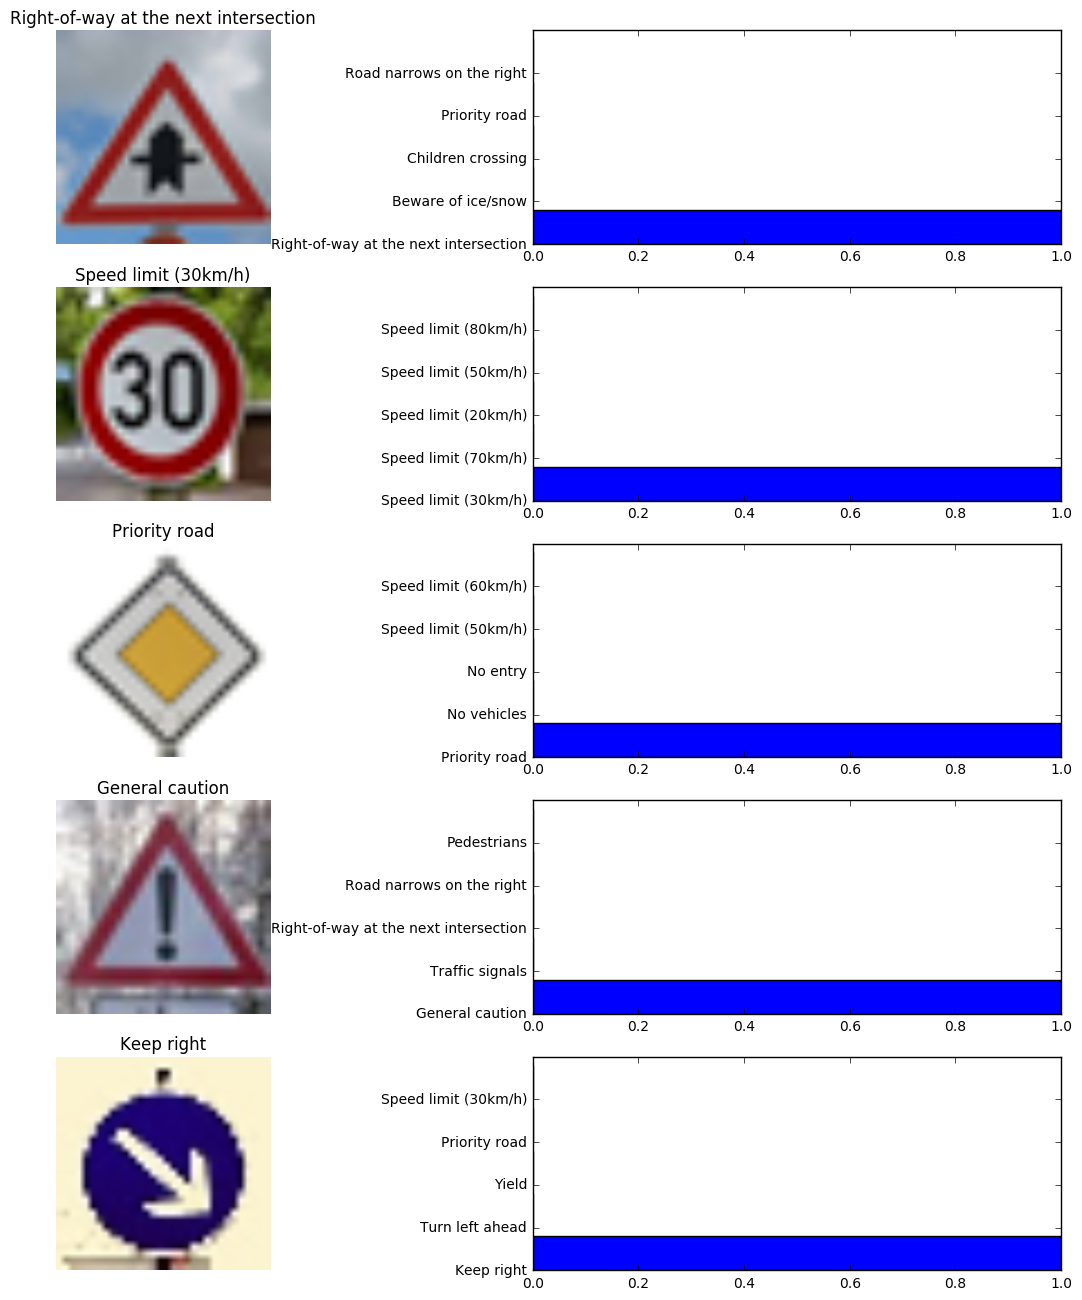

In [11]:
###############################################################################
## Test a Model on New Images

new_test_images = []
path = './Test_Images/'
for image in os.listdir(path):
    img = cv2.imread(path + image)
    img = cv2.resize(img, (32,32))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    new_test_images.append(img)
new_IDs = [11, 1, 12, 18, 38]
print("Number of new testing examples: ", len(new_test_images))

plt.figure(figsize=(15, 16))
for i in range(len(new_test_images)):
    plt.subplot(2, 5, i+1)
    plt.imshow(new_test_images[i])
    plt.xlabel(signs[new_IDs[i]])
    plt.ylabel("New testing image")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()

new_test_images_preprocessed = Preprocess_Data(new_test_images)

def y_predict_model(Input_data, top_k=5):
    """
    Generates the predictions of the model over the input data, and outputs the top softmax probabilities.
        Parameters:
            X_data: Input data.
            top_k (Default = 5): The number of top softmax probabilities to be generated.
    """
    num_examples = len(Input_data)
    y_pred = np.zeros((num_examples, top_k), dtype=np.int32)
    y_prob = np.zeros((num_examples, top_k))
    with tf.Session() as sess:
        saver.restore(sess,model_file)
        y_prob, y_pred = sess.run(tf.nn.top_k(tf.nn.softmax(LaNet_Logits), k=top_k), 
                             feed_dict={x:Input_data, keep_prob:1, keep_prob_conv:1})
    return y_prob, y_pred

y_prob, y_pred = y_predict_model(new_test_images_preprocessed)

test_accuracy = 0
for i in enumerate(new_test_images_preprocessed):
    accu = new_IDs[i[0]] == np.asarray(y_pred[i[0]])[0]
    if accu == True:
        test_accuracy += 0.2
print("New Images Test Accuracy = {:.1f}%".format(test_accuracy*100))

plt.figure(figsize=(15, 16))
for i in range(len(new_test_images_preprocessed)):
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(new_test_images[i]) 
    plt.title(signs[y_pred[i][0]])
    plt.axis('off')
    plt.subplot(5, 2, 2*i+2)
    plt.barh(np.arange(1, 6, 1), y_prob[i, :])
    labels = [signs[j] for j in y_pred[i]]
    plt.yticks(np.arange(1, 6, 1), labels)
plt.show()


In [12]:
###############################################################################
## Displaying intermediate outputs

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x: new_test_images_preprocessed, keep_prob: 1.0, keep_prob_conv:1.0})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(25,25))
    for featuremap in range(featuremaps):
        plt.subplot(8,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap='rainbow')
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap='rainbow')
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap='rainbow')
            

with tf.Session() as sess:

    saver.restore(sess, tf.train.latest_checkpoint('.'))
    conv1 = sess.graph.get_tensor_by_name('convolution0:0')
    outputFeatureMap(new_test_images_preprocessed,conv1, activation_min=-1, activation_max=-1, plt_num=1)
    
    conv1 = sess.graph.get_tensor_by_name('convolution1:0')
    outputFeatureMap(new_test_images_preprocessed,conv1, activation_min=-1, activation_max=-1, plt_num=2)
    
    conv2 = sess.graph.get_tensor_by_name('convolution2:0')
    outputFeatureMap(new_test_images_preprocessed,conv2, activation_min=-1, activation_max=-1, plt_num=3)
    
    conv2 = sess.graph.get_tensor_by_name('convolution3:0')
    outputFeatureMap(new_test_images_preprocessed,conv2, activation_min=-1, activation_max=-1, plt_num=4)

INFO:tensorflow:Restoring parameters from .\models
